In [1]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import sys, os, h5py, re
sys.path.append('..')
import matplotlib.pyplot as plt
from learning_utils import prepare_data_flexdmp, calc_loss_flexdmp
from check_dyn import plot_res_6dof
from trajencoder.flexdmp.flexdmp import FlexDMP
from algpr.ppgpr import PPGPR
from algpr.kernels import RBF

def setParams(network:torch.nn.Module, decay:float) -> list:
        ''' function to set weight decay
        '''
        params_dict = dict(network.named_parameters())
        params=[]
        weights=[]

        for key, value in params_dict.items():
            if key[-4:] == 'bias':
                params += [{'params':value,'weight_decay':0.0}]
            else:
                params +=  [{'params': value,'weight_decay':decay}]
        return params

In [2]:
class FlexDMPForcing(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(13, 50),
            nn.ReLU(),
            nn.Linear(50, 200),
            nn.ReLU(),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 50*6),
        )
        self.init_weights(self.net)
        
    def forward(self, x):
        return self.net(x)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(1.)

In [3]:
# just for dyna error calc
from casadi_kinodynamics.utils import symbolic_robot
sym_robot = symbolic_robot.symbolic_robot(robot_name='IRB1100_4_058',
                                          tool_mass=4.,
                                          tool_frame=[0., 0., 0.25, 0., 0., 0.],
                                          tool_cog=[0.0, 0., 0.12],
                                          tool_inertia=[
                                              0., 0., 0., 0., 0., 0.],
                                          load_casadi_fnc=True)

In [115]:
DMP_ORDER = 50

In [129]:
Xv, Yv, Trueth, qd_trueth, qdd_trueth, tau_trueth = prepare_data_flexdmp("../../data/6dof/Vali_orient_Box1ToBox2_4.0_mass.hdf5", FlexDMP, DMP_ORDER=DMP_ORDER, \
                                                             return_dyddy=True, return_tau=True, dof=6)

In [7]:
Yv.shape

(225, 301)

In [130]:
X, Y = np.load("X.npy"), np.load("Y.npy")

In [40]:
X, Y = [],[]
import glob
file_root = glob.glob("../../data/6dof/new_dynamics/Training_orient*")
for file in file_root:
    Xi, Yi, _ = prepare_data_flexdmp(file, FlexDMP, DMP_ORDER=DMP_ORDER, \
                                                                 return_dyddy=False, return_tau=False, dof=6)
    X.append(Xi)
    Y.append(Yi)

In [41]:
X = np.concatenate(X)
Y = np.concatenate(Y)

index_random = np.arange(len(X))
np.random.shuffle(index_random)
X = X[index_random]
Y = Y[index_random]

In [118]:
Yv.shape

(225, 301)

In [119]:
Y.shape

(53361, 301)

In [131]:
Y = Y[:,:-1]
Yv = Yv[:,:-1]

In [121]:
bias = Y.min(axis=0) - 20000
Y = Y - bias
Y = np.log(Y)

In [122]:
Yv = Yv - bias
Yv = np.log(Yv)

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Xtrain = torch.from_numpy(X).float().to(device)
Ytrain = torch.from_numpy(Y).float().to(device)

Xtest = torch.from_numpy(Xv).float().to(device)
Ytest = torch.from_numpy(Yv).float().to(device)

In [124]:
net = FlexDMPForcing().to(device)

In [125]:
param = setParams(net, decay=1e-1)
optimizer = Adam(params=param, lr=1e-3)
# optimizer = Adam(params=net.parameters(), lr=2e-3)
batch_size = 1000
Loss = nn.MSELoss()

In [126]:
Yv.shape

(225, 300)

(53361, 13)

In [127]:
net.train()
train_l, vali_l = [], []

for epoch in range(3000):
    L_t = 0.
    counter = 0
    index = np.arange(len(Xtrain))
    np.random.shuffle(index)
    for b_i in range(0, len(Xtrain)//batch_size):
        x_i = Xtrain[b_i*batch_size:(b_i+1)*batch_size, :]
        y_i = Ytrain[b_i*batch_size:(b_i+1)*batch_size, :]
        optimizer.zero_grad()
        pred = net(x_i)
        L = Loss(pred, y_i)
        L.backward()
        optimizer.step()
        L_t += L.item()
        counter += 1
    with torch.no_grad():
        net.eval()
        pred = net(Xtest)
        L = Loss(pred, Ytest)
        vali_l.append(L.item())
        train_l.append(L_t/counter)
        net.train()
    if epoch % 30 == 0:
        print("Train: ", L_t/counter, "Vali: ", L.item())

Train:  29.445615477719397 Vali:  0.7676674723625183
Train:  0.03538546250816786 Vali:  0.030244000256061554
Train:  0.024943577898841985 Vali:  0.025863274931907654
Train:  0.017920769434773696 Vali:  0.01713629998266697
Train:  0.015484283432223887 Vali:  0.016921035945415497
Train:  0.0059452798296609575 Vali:  0.008176600560545921
Train:  0.008377227194185526 Vali:  0.006017738953232765
Train:  0.007375761163684557 Vali:  0.006310233846306801
Train:  0.007351101876921811 Vali:  0.007477832958102226
Train:  0.007289202615864716 Vali:  0.007626985665410757
Train:  0.007472529032109481 Vali:  0.008534125052392483
Train:  0.007492184946489222 Vali:  0.008641590364277363
Train:  0.007216465769265339 Vali:  0.00856253132224083
Train:  0.007361197738714938 Vali:  0.008630833588540554
Train:  0.007290490560303882 Vali:  0.00872583594173193
Train:  0.0072387674876119735 Vali:  0.008681497536599636
Train:  0.007180680889847144 Vali:  0.008915458805859089
Train:  0.007144877080858316 Vali:  0

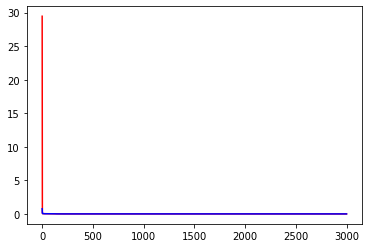

In [128]:
plt.plot(train_l, '-r')
plt.plot(vali_l, '-b')

In [132]:
net.eval()
pred = net(Xtest)
pred = pred.detach().cpu().numpy()
pred = np.exp(pred)
pred += bias

In [133]:
GP_pred = np.load("GP_pred.npy")

In [134]:
np.abs(Yv - pred).sum(axis=0).max()

7904202.059262243

In [135]:
np.abs(Yv - GP_pred[:, :-1]).sum(axis=0).max()

7877423.859718961

/tmp/ipykernel_8461/45018254.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[10,3.5])


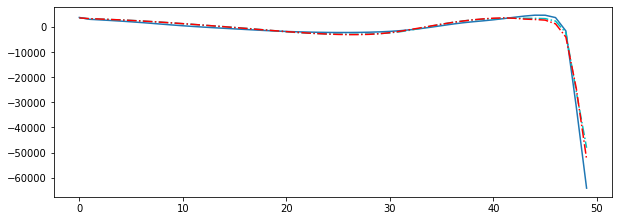

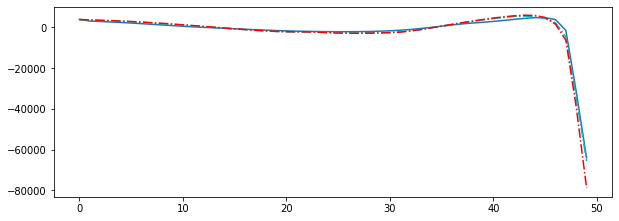

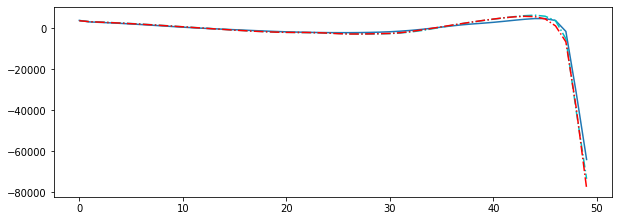

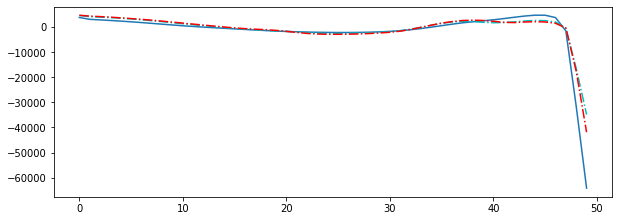

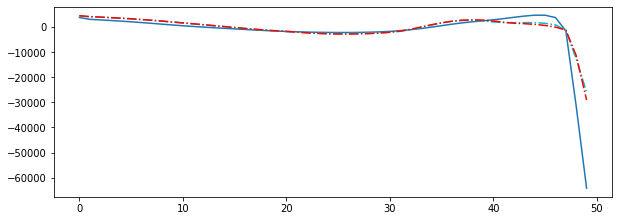

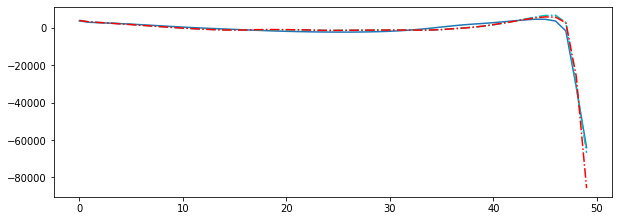

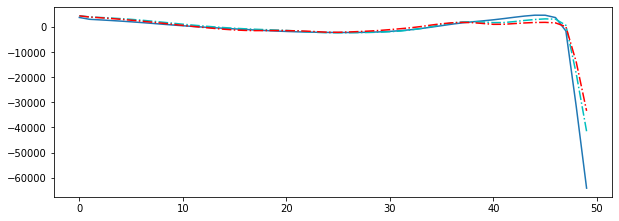

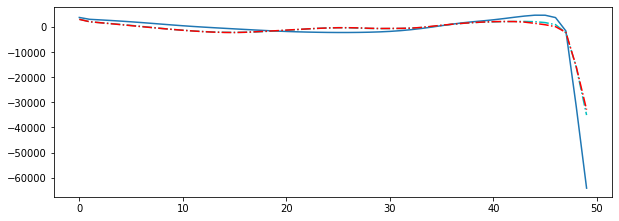

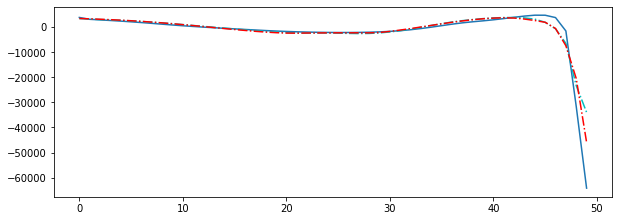

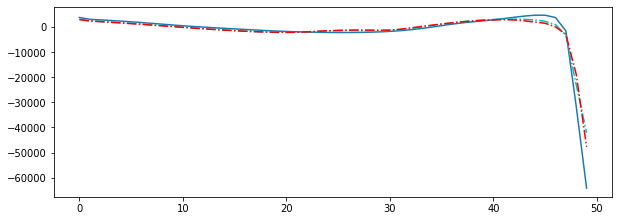

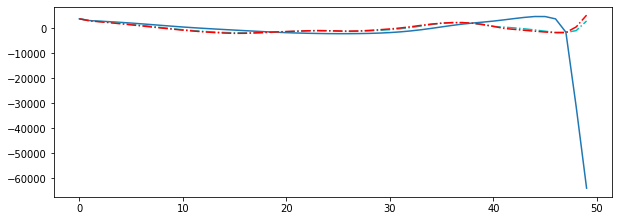

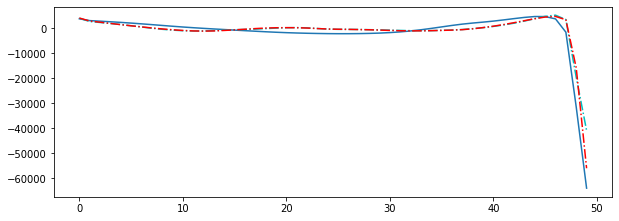

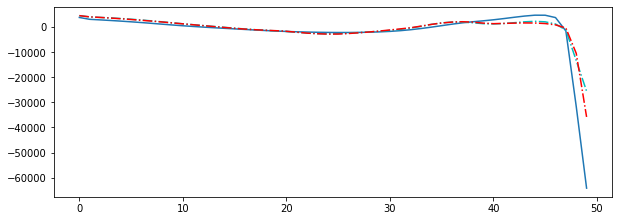

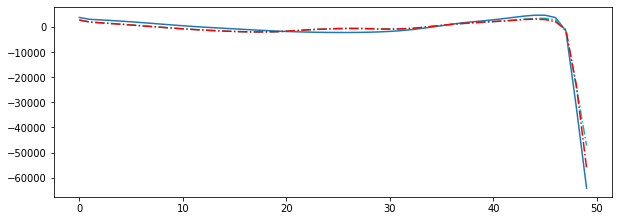

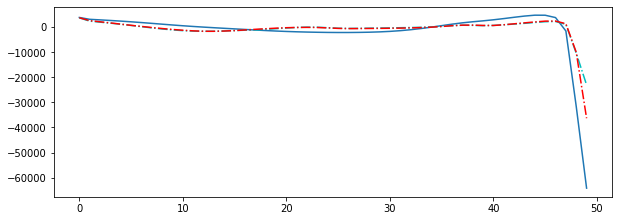

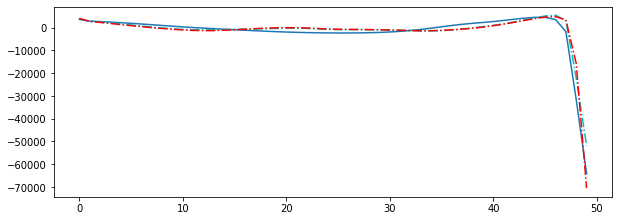

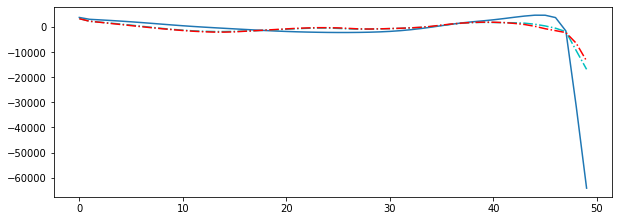

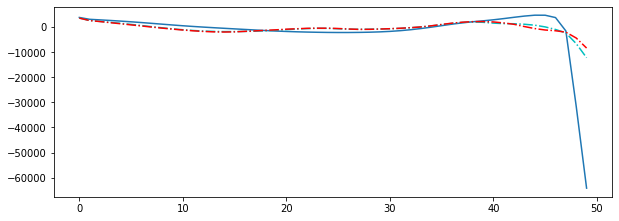

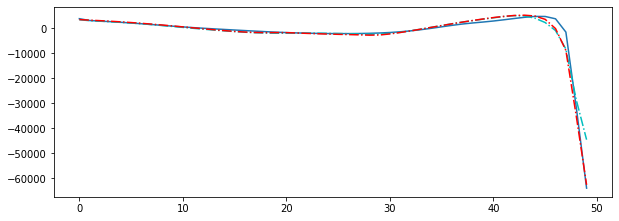

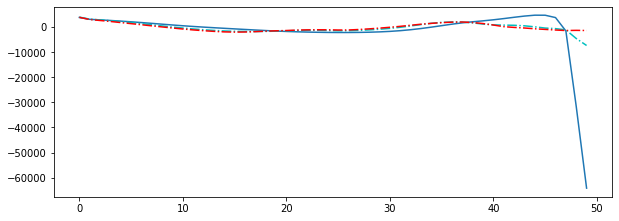

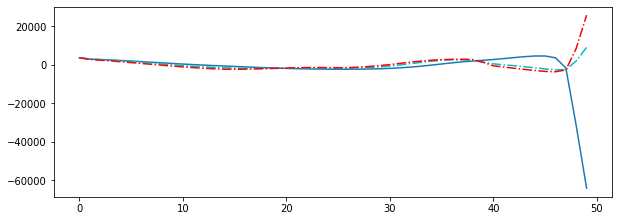

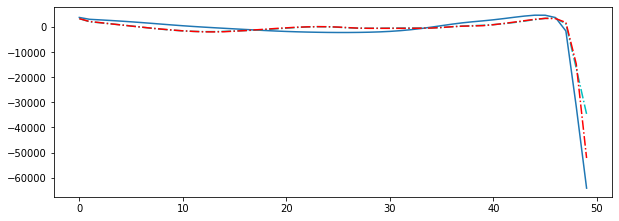

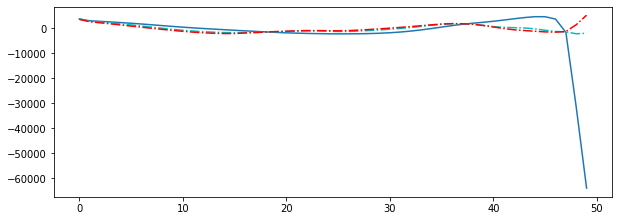

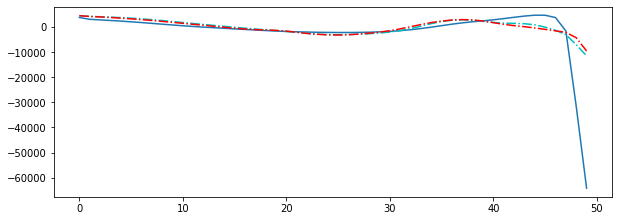

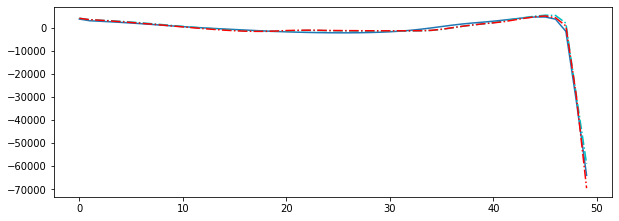

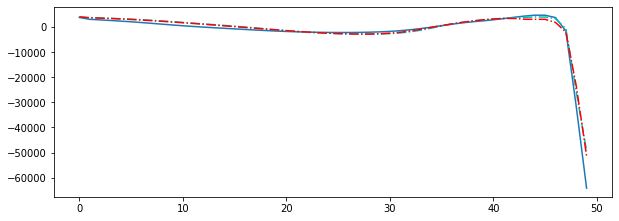

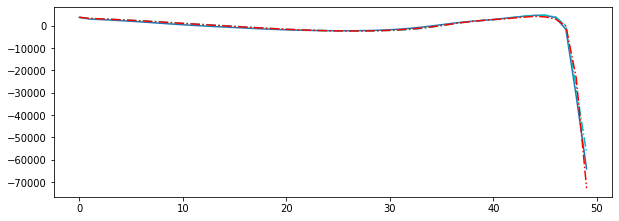

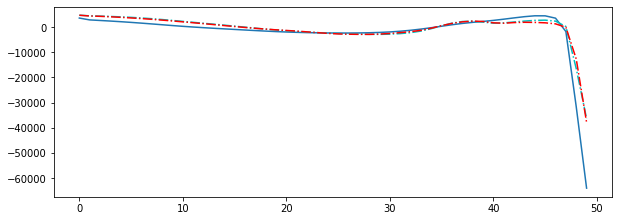

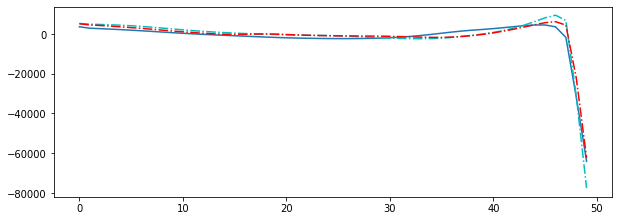

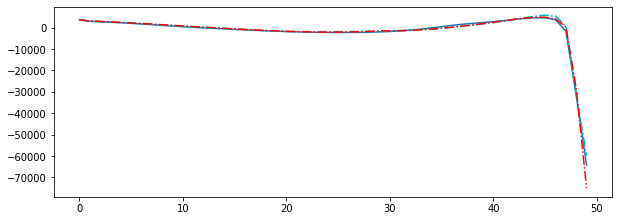

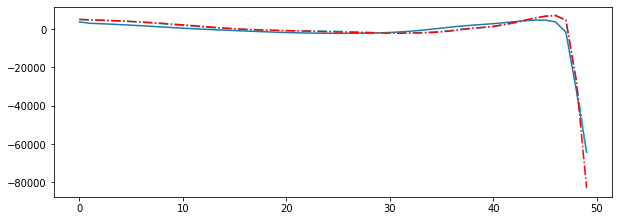

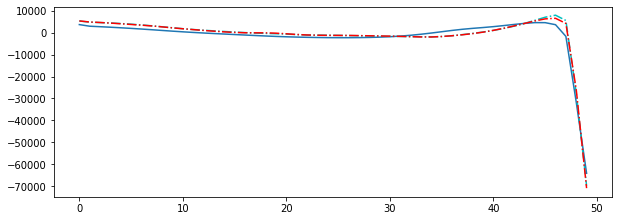

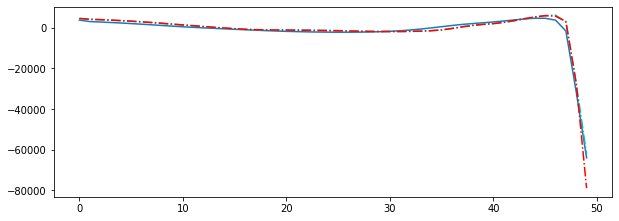

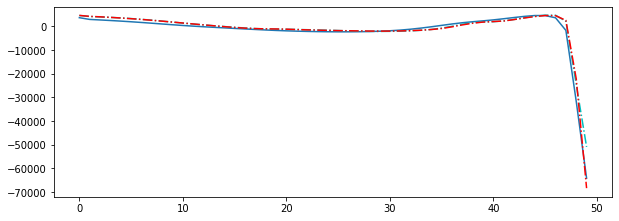

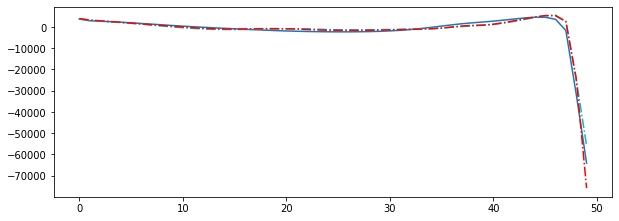

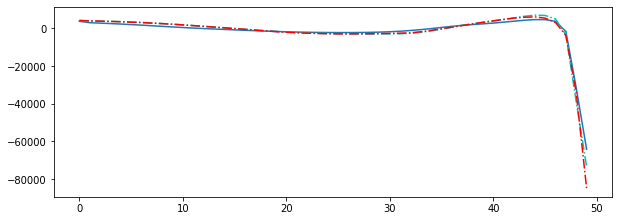

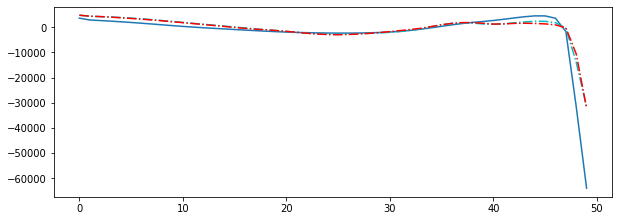

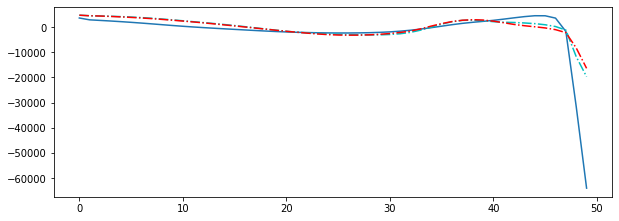

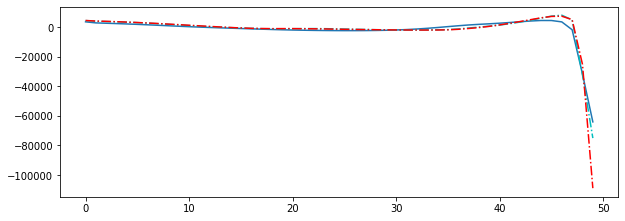

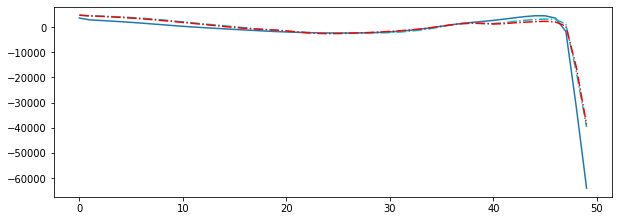

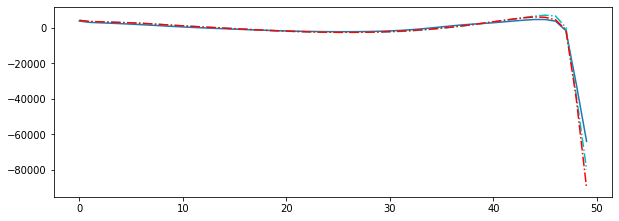

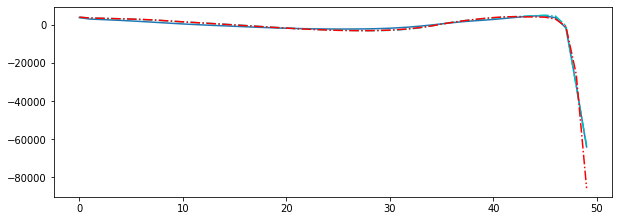

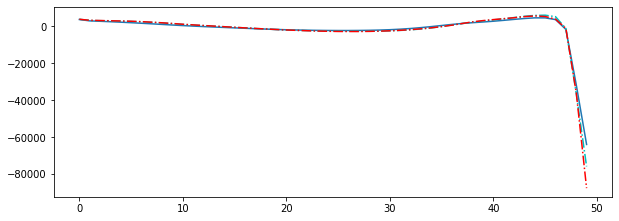

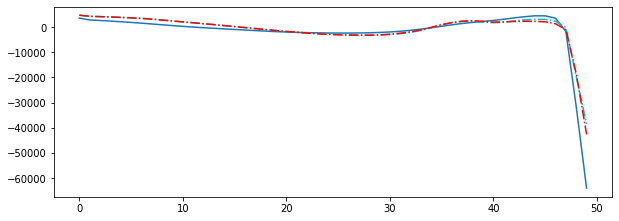

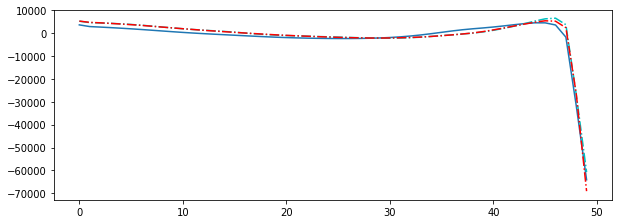

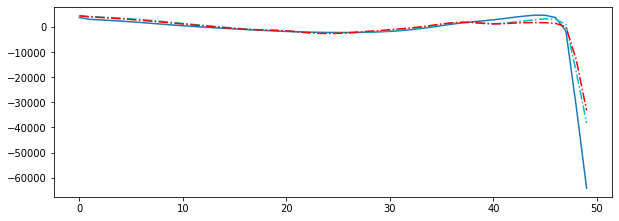

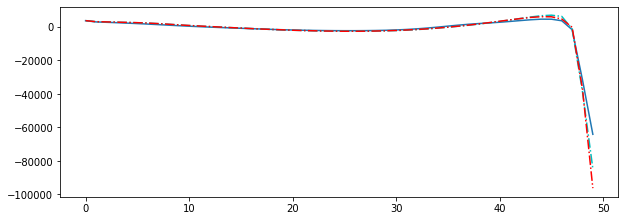

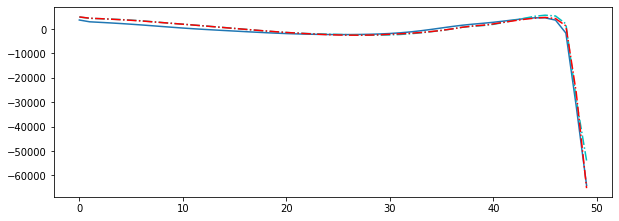

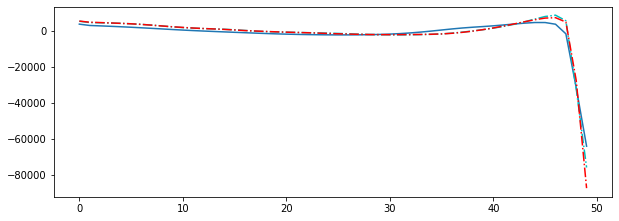

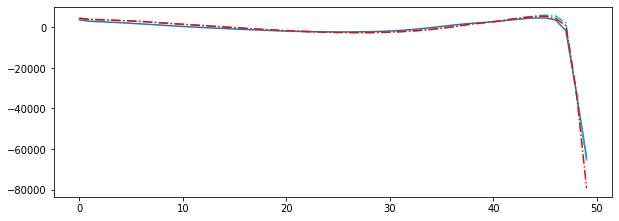

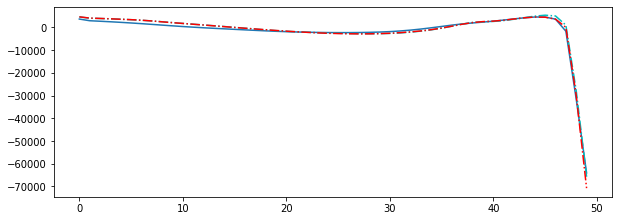

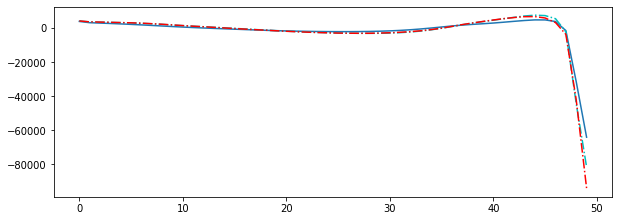

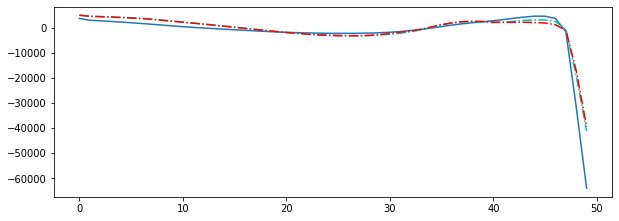

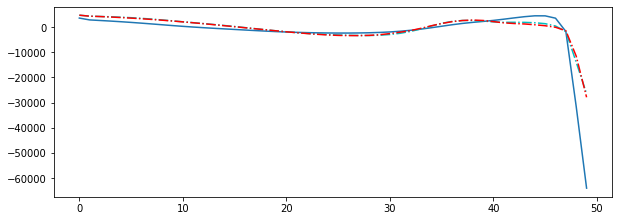

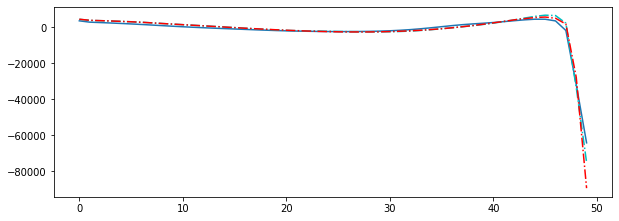

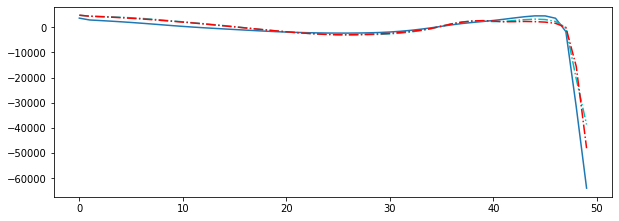

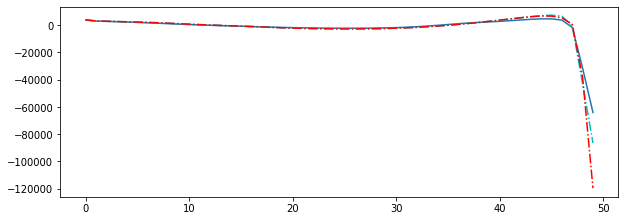

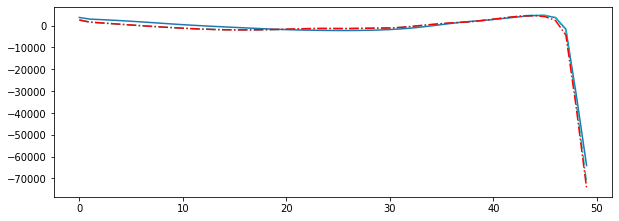

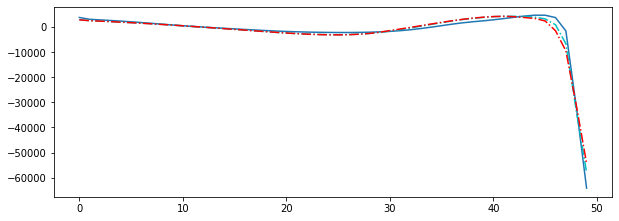

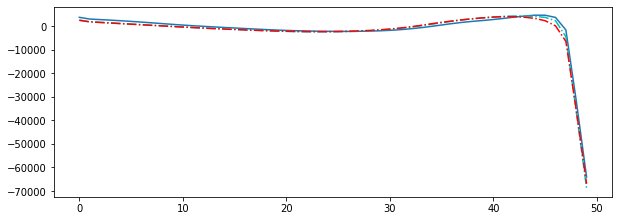

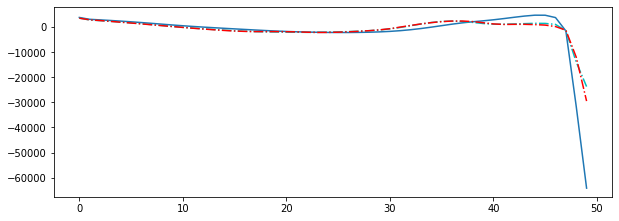

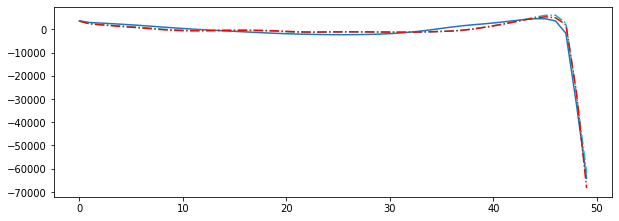

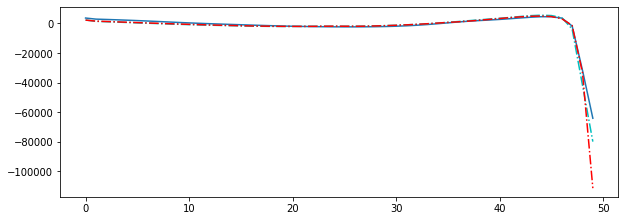

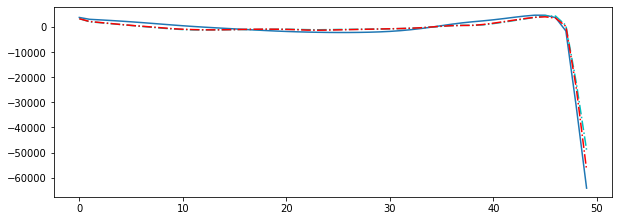

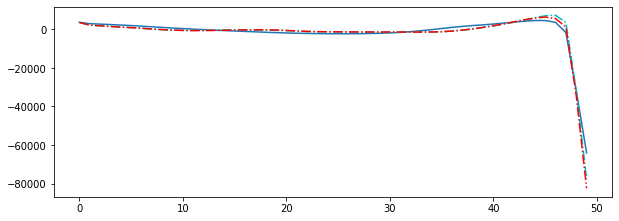

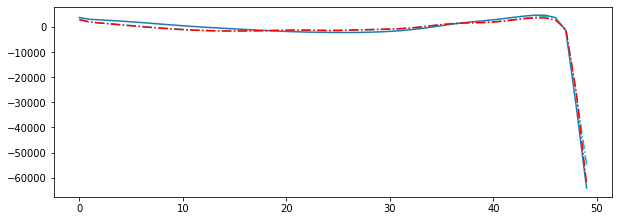

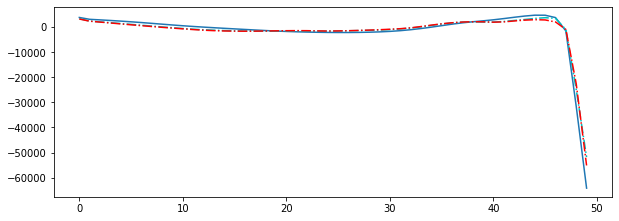

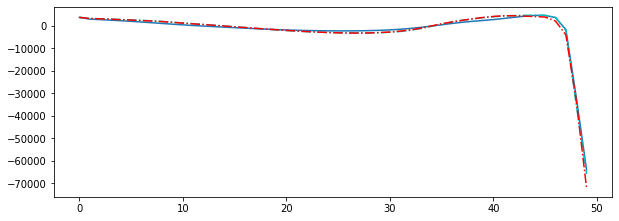

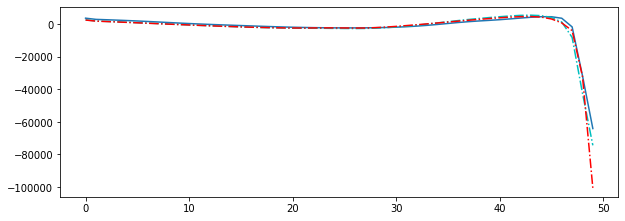

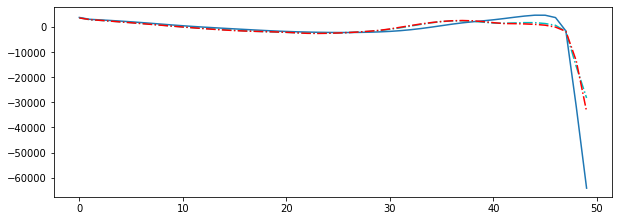

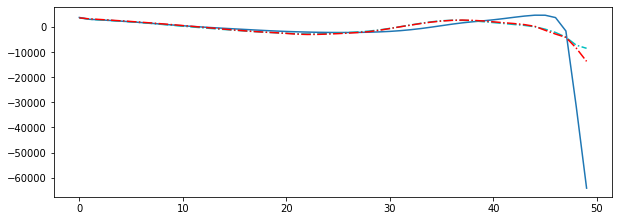

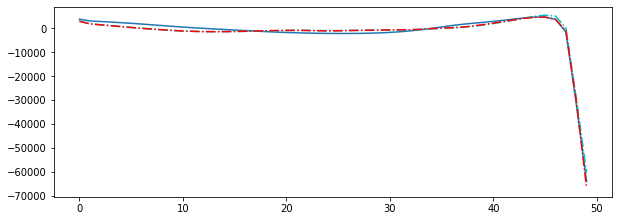

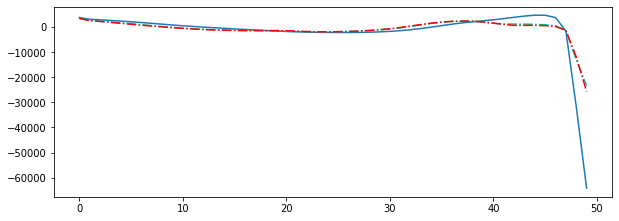

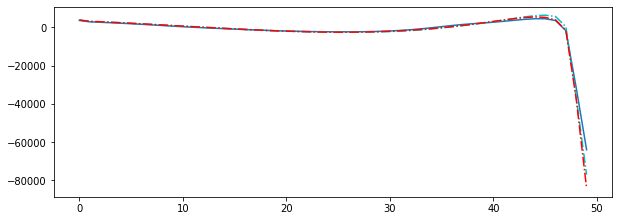

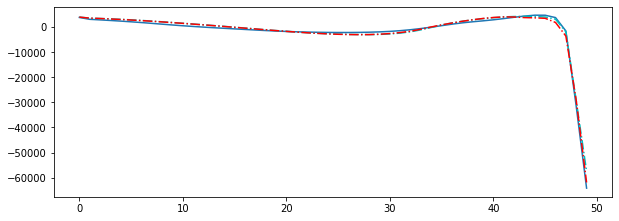

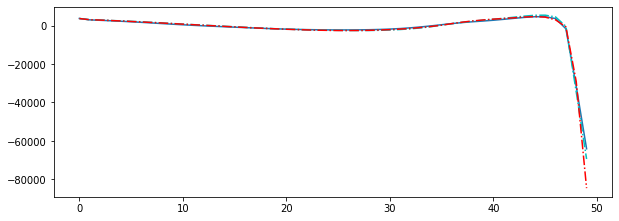

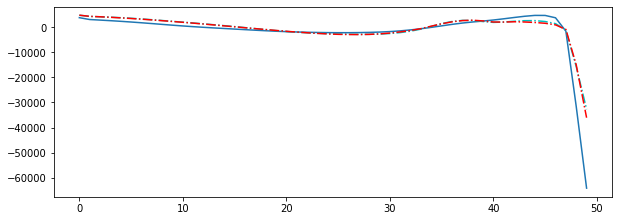

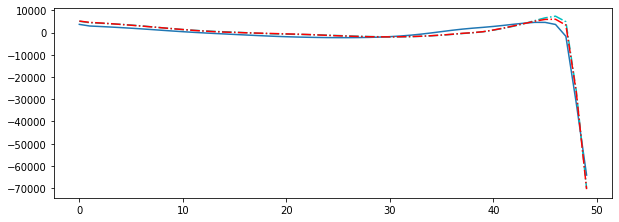

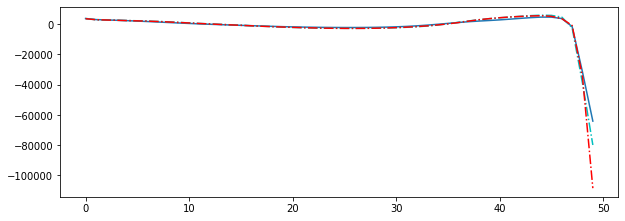

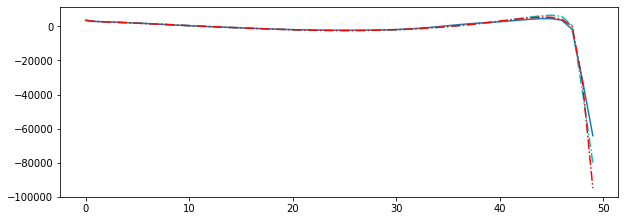

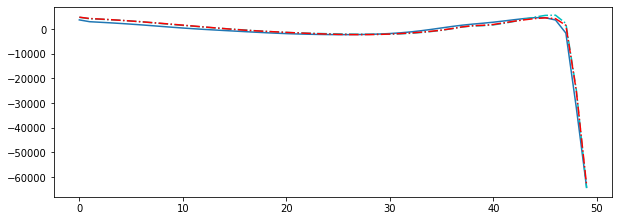

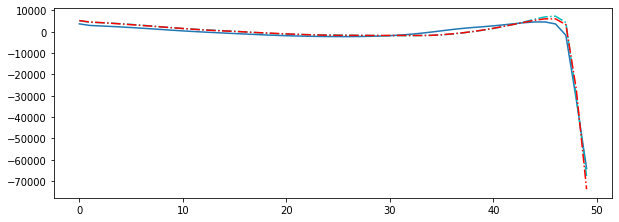

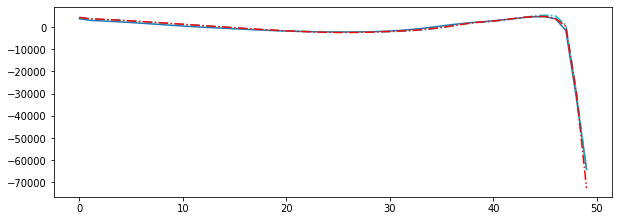

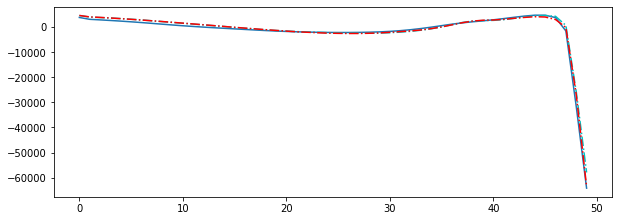

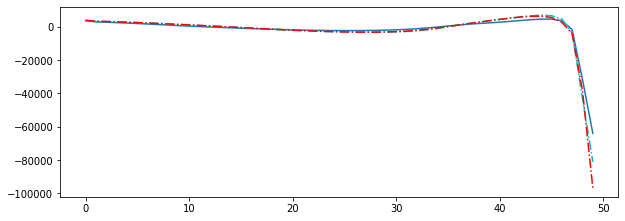

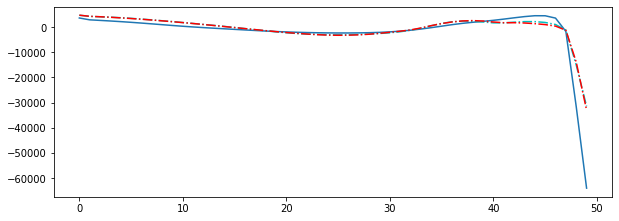

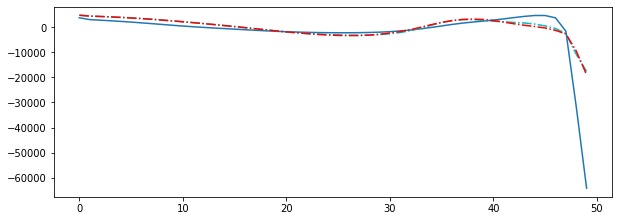

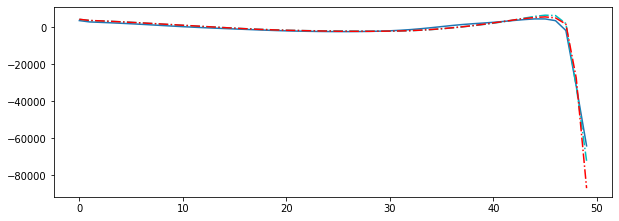

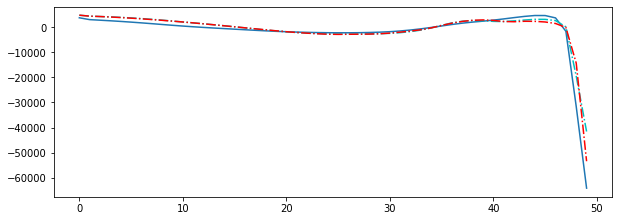

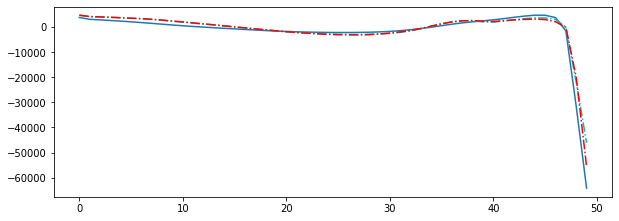

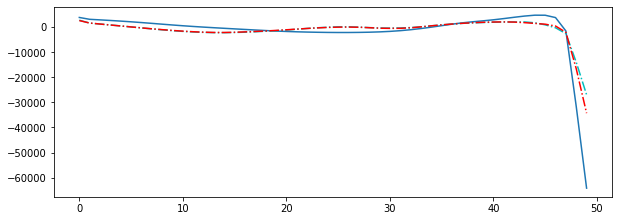

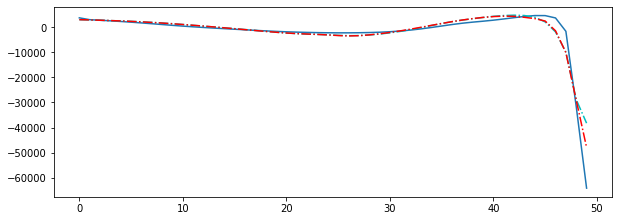

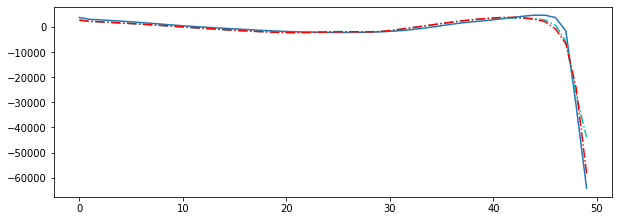

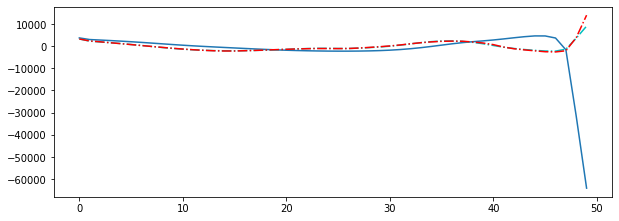

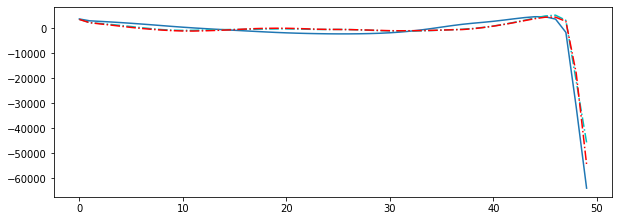

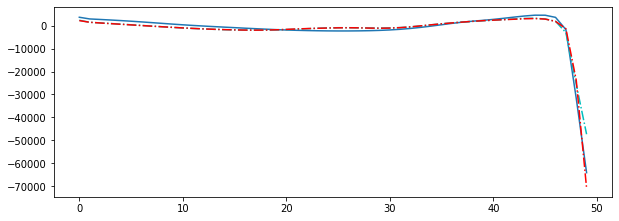

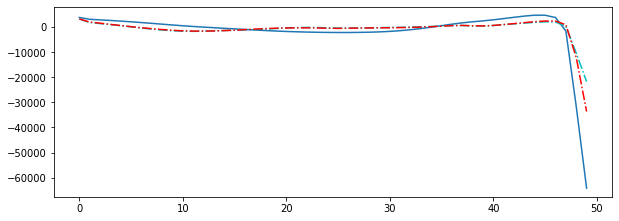

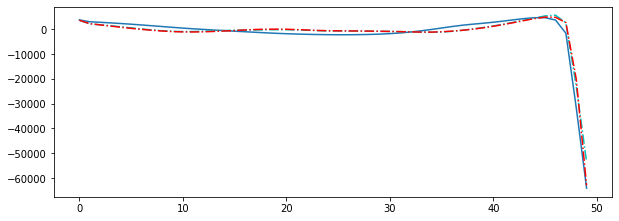

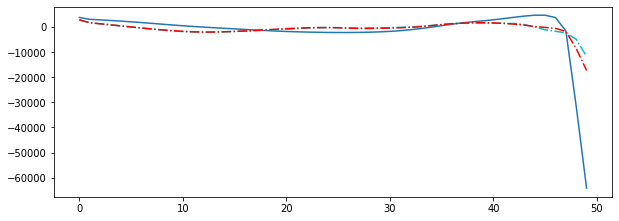

In [136]:
joint = 5
for ind in range(1,100):
    plt.figure(figsize=[10,3.5])
    plt.plot(pred[ind,joint*DMP_ORDER:(joint+1)*DMP_ORDER])
    plt.plot(GP_pred[ind,joint*DMP_ORDER:(joint+1)*DMP_ORDER], '-.c')
    plt.plot(Yv[ind,joint*DMP_ORDER:(joint+1)*DMP_ORDER], '-.r')

In [105]:
torch.save( net.state_dict(), "../../learning/weight.pth" ) 